# stochastic analysis of COVID19 time series in "Baden-Württemberg"
data as of 10.06.2020 by https://sozialministerium.baden-wuerttemberg.de/de/gesundheit-pflege/gesundheitsschutz/infektionsschutz-hygiene/informationen-zu-coronavirus/lage-in-baden-wuerttemberg/

algorithm from "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec [1]

In [2]:
import pandas as pd
import numpy as np
from scipy import signal, stats, special
from scipy.optimize import curve_fit
from scipy.integrate import quad, solve_ivp
import matplotlib.pyplot as plt
import datetime

## 1. extract values from selected list
variables names: *I: Infected; *T: Deceased

In [194]:
filename = 'Tabelle_Coronavirus-Faelle-BW.xlsx'
dfi = pd.read_excel(filename, sheet_name='Infizierte Coronavirus in BW', header=None)
dft = pd.read_excel(filename, sheet_name='Todesfälle Coronavirus in BW', header=None)

In [195]:
ctyI = np.nan_to_num(np.asarray(dfi))
ctyT = np.nan_to_num(np.asarray(dft))
# row 7: dates
# row 8 to 51: regions
    # row 18: Freiburg
    # row 38: Ravensburg
# row 52: sum

### 1.1 plot regional data

In [240]:
index = 17
region = ctyI[index][0]
title = 'Corona cases in %s' % region

# calculate x data: dates
# currently: approximation where each month is approximated by 30 days.
xI = [el.day+el.month*30 if type(el) == datetime.datetime else False for el in ctyI[6]]
xT = [el.day+el.month*30 if type(el) == datetime.datetime else False for el in ctyT[6]]

# calculate trajectory points from data of given index
yI = [el if type(el) == int else False for el in ctyI[index]]
yT = [el if type(el) == int else False for el in ctyT[index]]

# remove first element of lists (column of regions, only str in these)
del xI[0]
del xT[0]
del yI[0]
del yT[0]

# flip arrays
xI = np.flip(xI)
xT = np.flip(xT)
yI = np.flip(yI)
yT = np.flip(yT)

# Calculate new cases per day
dyIdt = np.diff(yI, prepend=0)
    
# Calculate new deaths per day
dyTdt = np.diff(yT,prepend=0)

# Checking for mistakes
print('I1:', len(xI) == len(yI))
print('T1:', len(xT) == len(yT))
print('dIdt:', len(xI) == len(dyIdt))
print('dTdt:', len(xT) == len(dyTdt))
checksum = 0
for el in dyIdt:
    checksum += el
print("checksum I:", checksum == yI[-1])
checksum = 0
for el in dyTdt:
    checksum += el
print("checksum T:", checksum == yT[-1])

I1: True
T1: True
dIdt: True
dTdt: True
checksum I: True
checksum T: True


<IPython.core.display.Javascript object>


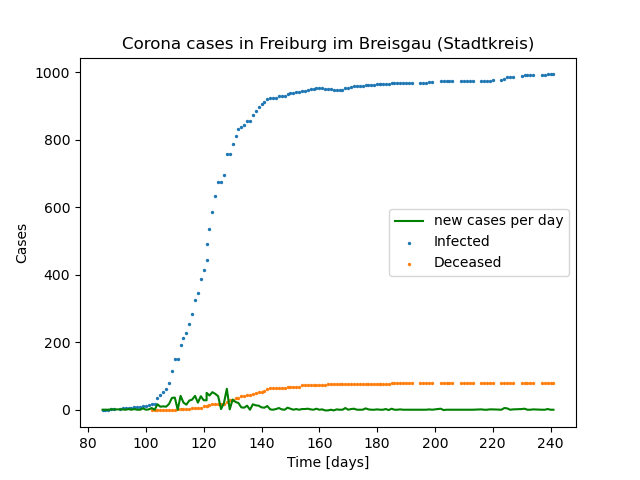

In [245]:
# Plot infected, deceased and new cases per day
%matplotlib notebook
plt.scatter(xI, yI, label='Infected', s=2)
plt.scatter(xT, yT, label='Deceased', s=2)
plt.plot(xI, dyIdt, label='new cases per day', c='g')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title(title)
plt.legend()
plt.show()
#plt.savefig('%sCases.png' % region)

### 1.2 plot total data

In [229]:
# calculation of x-data in cell above

# calculate total sum
yI_total = [el for el in ctyI[51]]
yT_total = [el for el in ctyT[51]]

# remove first element of lists (column of regions, only str in these)
del yI_total[0]
del yT_total[0]

# flip arrays
yI_total = np.flip(yI_total)
yT_total = np.flip(yT_total)

# Calculate new cases per day
dyI_totaldt = np.diff(yI_total, prepend=0)
    
# Calculate new deaths per day
dyT_totaldt = np.diff(yT_total, prepend=0)
    
# Checking for mistakes
print('I2:', len(xI) == len(yI_total))
print('T2:', len(xT) == len(yT_total))
print('dI_totaldt:', len(xI) == len(dyI_totaldt))
print('dT_totaldt:', len(xT) == len(dyT_totaldt))
checksum = 0
for el in dyI_totaldt:
    checksum += el
print("checksum I:", checksum == yI_total[-1])
checksum = 0
for el in dyT_totaldt:
    checksum += el
print("checksum T:", checksum == yT_total[-1])

I2: True
T2: True
dI_totaldt: True
dT_totaldt: True
checksum I: True
checksum T: True


<IPython.core.display.Javascript object>


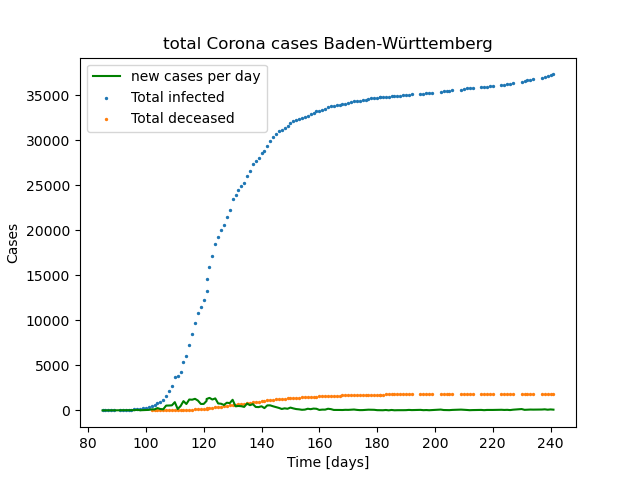

In [228]:
# Plot infected, deceased and new cases per day
%matplotlib notebook
plt.scatter(xI, yI_total, label='Total infected', s=2)
plt.scatter(xT, yT_total, label='Total deceased', s=2)
plt.plot(xI, dyI_totaldt, label='new cases per day', c='g')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title('total Corona cases Baden-Württemberg')
plt.legend()
plt.show()
#plt.savefig('BWCases.png')

## 2. perquisites for stochastic analysis

### 2.1 noised HO data
We will use the harmonic oscillator (HO) as example data. In the following, noised data will be created. Using the commonly known analytical solution of HO:

$$
\dot{x} = v\\
\dot{v} = -x + \Gamma(t) - \gamma v
$$

In [113]:
dt = 0.001
T = 1000
n = int(T / dt)
sqrtdt = np.sqrt(dt)

gamma = 0
epsilon = .1

x = np.zeros(n)
v = np.zeros(n)

x[0] = 1
v[0] = 0

for i in range(n - 1):
    x[i + 1] = x[i] + dt * v[i]
    v[i + 1] = v[i] - dt * (x[i + 1] + gamma * v[i]) + sqrtdt * np.random.randn() * epsilon # using x[i + 1] instead of x[i]

<IPython.core.display.Javascript object>


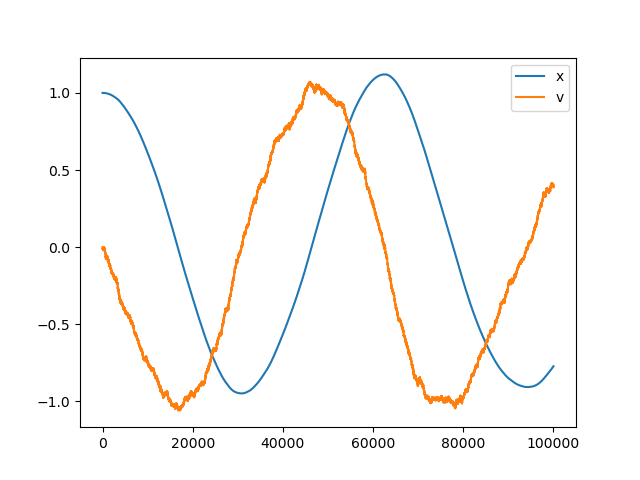

In [114]:
%matplotlib notebook
plt.plot(x[:1000], label='x')
plt.plot(v[:1000], label='v')
#plt.scatter(x, v, s=1, label='phaseplot')

plt.legend()
plt.show()

### 2.2 Drift and Diffusion coefficients on HO

They are defined in \[1\](4) as

$$
D^{(1)}_{i} = \lim_{\tau \to 0} \frac{1}{\tau} < X_i(t + \tau) - x_i >_{X(t) = \vec{x}}
\\
D^{(2)}_{ij} = \lim_{\tau \to 0} \frac{1}{\tau} < (X_i(t + \tau) - x_i)(X_j(t + \tau) - x_j) >_{X(t) = \vec{x}}
$$

In case of HO they write:
$$
D^{(1)}_{x} = \lim_{\tau \to 0} \frac{1}{\tau} < x(t + \tau) - x(t) >
\\
D^{(1)}_{v} = \lim_{\tau \to 0} \frac{1}{\tau} < v(t + \tau) - v(t) >
$$

In [110]:
def D_1(s, i, x, tau=1, bins=100):
    '''Retrieving Drift-Coefficient
    '''
    s[i] = np.array(s[i])
    indices = np.where(abs(s[i][:-tau] - x[i]) <= (1 / bins)) # times where the series equals IVP
    
    f = lambda tau: (1 / tau) * np.mean([s[i][t + tau] - x[i] for t in indices])
    
    result = f(tau)
    
    return result

In [115]:
arx = np.linspace(-5, 5, 250)

x_output = [D_1([x, v], 0, [ax, 0]) for ax in arx]
v_output = [D_1([x, v], 1, [0, ax]) for ax in arx]

c:\users\franz\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\franz\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


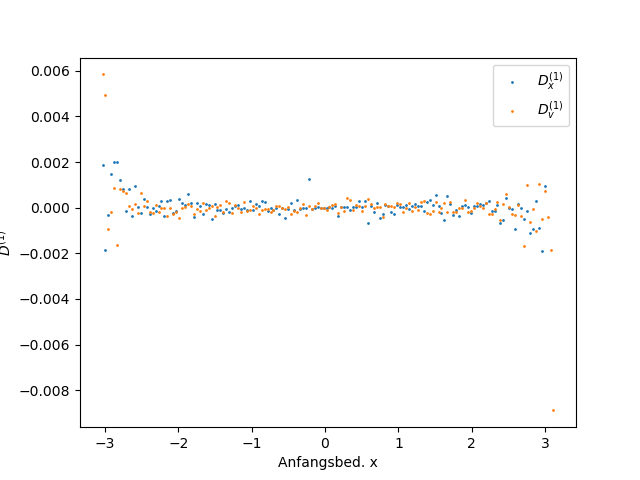

In [116]:
%matplotlib notebook
plt.scatter(arx, x_output, s=1, label='$D^{(1)}_x$')
plt.scatter(arx, v_output, s=1, label='$D^{(1)}_v$')

#plt.plot(arx, x_output, label='$D^{(1)}_x$')
#plt.plot(arx, v_output, label='$D^{(1)}_v$')

plt.xlabel('Anfangsbed. x')
plt.ylabel('$D^{(1)}$')
plt.legend()

plt.show()

## literature

[1] "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec

[2] "Simulation - Advanced Topics" by A.Greiner as of June 11, 2020

[3] "The Fokker-Planck Equation" by H.Risken as of 1996